<a href="https://colab.research.google.com/github/mtodisco10/fastaiProjects/blob/master/first_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_137.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_52.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_13.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_90.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_41.jpg')]

In [ ]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


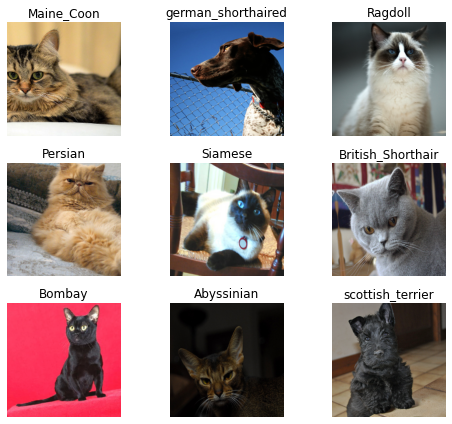

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
folder = 'modern'
file = 'modern.csv'

path = Path('architecture/buildings')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(file, dest, max_pics=200)

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

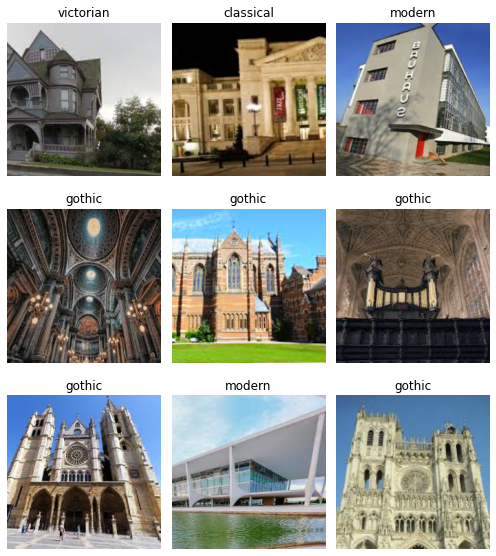

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
classes = ['classical', 'gothic', 'modern', 'victorian']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

classical


gothic


modern


victorian


# Train the Model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.290565,1.859166,0.712500,00:05
1,1.932337,0.895671,0.325000,00:04
2,1.600253,0.618307,0.250000,00:04
3,1.322603,0.551148,0.237500,00:04
4,1.132275,0.551495,0.225000,00:04


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

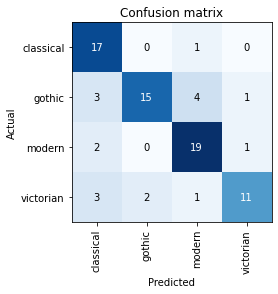

In [ ]:
interp.plot_confusion_matrix()

In [1]:
print('This isn\'t too shabby for a first try')

This isn't too shabby for a first try
